In [231]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt
from ml import train
from dataloading import get_data, build_features

%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

cfgs, btests = [], []
for p in sorted(Path("optimization").glob("*.pickle")):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)
    print(p)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
optimization/btest000.pickle
optimization/btest001.pickle
optimization/btest002.pickle
optimization/btest003.pickle
optimization/btest004.pickle
optimization/btest005.pickle
optimization/btest006.pickle
optimization/btest007.pickle
optimization/btest008.pickle
optimization/btest009.pickle
optimization/btest010.pickle
optimization/btest011.pickle
optimization/btest012.pickle
optimization/btest013.pickle
optimization/btest014.pickle
optimization/btest015.pickle
optimization/btest016.pickle
optimization/btest017.pickle
optimization/btest018.pickle
optimization/btest019.pickle
optimization/btest020.pickle
optimization/btest021.pickle
optimization/btest022.pickle
optimization/btest023.pickle
optimization/btest024.pickle
optimization/btest025.pickle
optimization/btest026.pickle
optimization/btest027.pickle
optimization/btest028.pickle
optimization/btest029.pickle
optimization/btest030.pickle
optimization/

In [232]:
from backtest import DataParser, MovingWindow
import numpy as np


fsize = 64
tfdict = {"M5":0, "M15":1, "H1":2}
X, y, poslist = [], [], []
for btest in btests:
    print(btest.cfg.ticker, end=" ")
    hist_pd, hist = DataParser(btest.cfg).load()
    mw = MovingWindow(hist, fsize+2)
    print(len(btest.positions))
    for pos in btest.positions[4:]:
        f, _ = mw(pos.open_indx)
        x = build_features(f, 
                           pos.dir, 
                           btest.cfg.stops_processor.func.cfg.sl, 
                           btest.cfg.trailing_stop_rate,
                           pos.open_date, 
                           tfdict[btest.cfg.period])
        X.append([x])
        y.append(pos.profit)
        poslist.append(pos)
        
X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
print(X.shape, y.shape)
print(f"{X[0, 0, -2, 0]:8.0f} -> {X[-1, 0, -2, 0]:8.0f}")

BTCUSD 314
ETHUSD 354
BTCUSD 219
ETHUSD 295
BTCUSD 180
ETHUSD 241
BTCUSD 151
ETHUSD 216
BTCUSD 392
ETHUSD 433
BTCUSD 287
ETHUSD 337
BTCUSD 254
ETHUSD 304
BTCUSD 213
ETHUSD 268
BTCUSD 427
ETHUSD 472
BTCUSD 347
ETHUSD 377
BTCUSD 292
ETHUSD 346
BTCUSD 272
ETHUSD 312
BTCUSD 453
ETHUSD 515
BTCUSD 389
ETHUSD 418
BTCUSD 338
ETHUSD 387
BTCUSD 314
ETHUSD 354
(10343, 1, 9, 64) (10343,)
20180600 -> 20201230


  iter     pboost    pboost mean    pboost median    pboost std
------  ---------  -------------  ---------------  ------------
     0   1.06465         1.06465          1.06465       0
     1   9.13913         5.10189          5.10189       4.03724
     2   1.89702         4.0336           1.89702       3.62611
     3   2.1959          3.57417          2.04646       3.23956
     4   1.10169         3.07968          1.89702       3.06168
     5   1.40066         2.79984          1.64884       2.86411
     6   0.781597        2.51152          1.40066       2.74409
     7   1.44164         2.37778          1.42115       2.59113
     8   1.31043         2.25919          1.40066       2.46586
     9   1.11147         2.14442          1.35554       2.36453
    10   0.969007        2.03756          1.31043       2.27967
    11   2.47322         2.07387          1.35554       2.18594
    12   1.2702          2.01205          1.31043       2.11107
    13   0.987446        1.93886          1.29

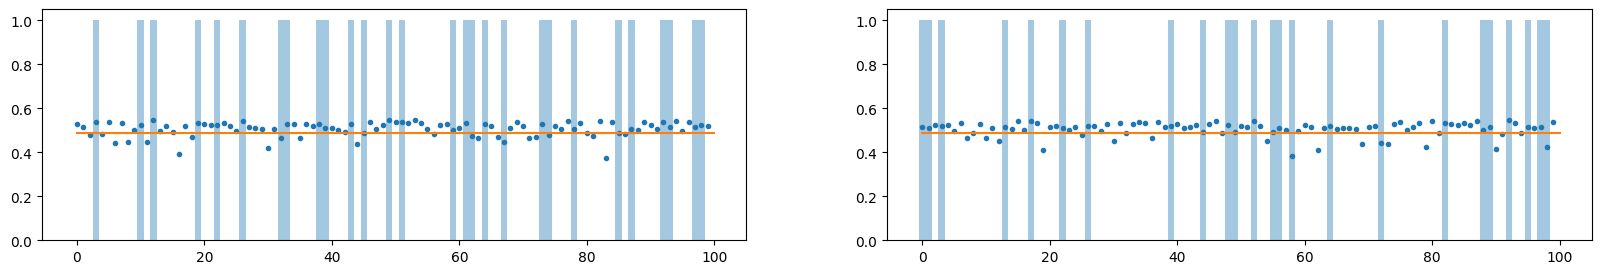

In [237]:
from sklearn.metrics import f1_score
import torch
device = "mps"

nitrers = 100
test_split_size = 0.2
calc_test = False
id2tf = {v:k for k, v in tfdict.items()}

pprofits, gprofits, metrics, table = np.zeros((3, nitrers)), np.zeros((3, nitrers)), np.zeros((2, nitrers)), []
for i in range(nitrers):
    np.random.seed(i)
    X_train, X_test, y_train, y_test, profs_train, profs_test, tf_test = get_data(X, y, test_split_size)
    model = train(X_train, y_train, X_test, y_test, batch_size=512, device=device, calc_test=calc_test)
    model.eval()
    p_train = model(torch.tensor(X_train).float().to(device)).detach().cpu().numpy().squeeze()[:, 0]
    p_test = model(torch.tensor(X_test).float().to(device)).detach().cpu().numpy().squeeze()[:, 0]
    threshold = np.percentile(p_train, 20)
    # profsum_best, threshold = -999999, None
    # for th in np.arange(0.1, 1, 0.025):
    #     # profsum = (profs_train*(p_train>th)).sum()
    #     profsum = f1_score(p_train>th, y_train[:, 0])
    #     if profsum > profsum_best:
    #         profsum_best = profsum
    #         threshold = th
    metrics[0, i] = f1_score(p_train>threshold, y_train[:, 0])
    # print(f"{i:03} f1_train: {metrics[0, i]:5.3f}", end=" ")
    if test_split_size > 0:
        metrics[1, i] = f1_score(p_test>threshold, y_test[:, 0])
        # print(f"f1_test: {metrics[1, i]:5.3f}")
        
        for j in range(3):
            ids = tf_test == j
            pprofits[j, i] = (profs_test[ids]*(p_test[ids]>threshold)).sum()
            gprofits[j, i] = profs_test[ids].sum()
            # print(f"{i:03} profit {id2tf[j]:3}:{gprofits[j, i]:+7.1f} -> {pprofits[j, i]:+7.1f} {'OK' if pprofits[j, i] > gprofits[j, i] else '--'}")
        
        prof_boost_mean = np.nanmean(pprofits[:, :i+1]/gprofits[:, :i+1])
        prof_boost_median = np.nanmedian((pprofits[:, :i+1]/gprofits[:, :i+1]))
        prof_boost_std = np.nanstd(pprofits[:, :i+1]/gprofits[:, :i+1])
        clear_output(wait=True)
        table.append([i, np.nanmean(pprofits[:, i]/gprofits[:, i]), prof_boost_mean, prof_boost_median, prof_boost_std])
        print(tabulate(table, headers=["iter", "pboost", "pboost mean", "pboost median", "pboost std"]))

    else:
        print()
plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(p_train[:100], ".")
plt.bar(np.arange(100), y_train[:100, 0], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])
if len(p_test):
    plt.subplot(1, 2, 2)
    plt.plot(p_test[:100], ".")
    plt.bar(np.arange(100), y_test[:100, 0], width=[1]*100, alpha=0.4)
    # plt.bar(np.arange(100), profs_test[:100], width=[1]*100, alpha=0.2)
    plt.plot([0, 100], [threshold, threshold])
    
model.set_threshold(threshold)
torch.save(model.state_dict(), "model.pth")

1.810294884037553 1.1680000511964643 2.7205883696726745


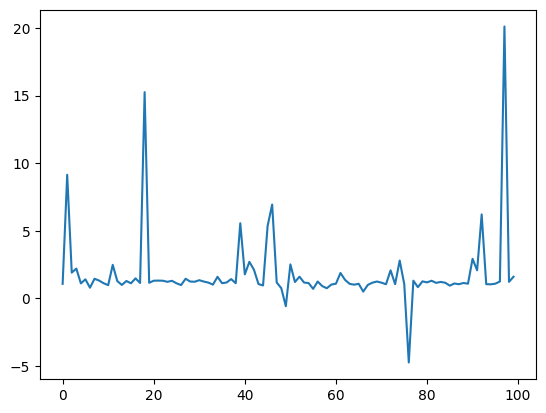

In [238]:
prof_boost = pprofits[2, :i]/gprofits[2, :i]
print(np.mean(prof_boost), np.median(prof_boost), np.std(prof_boost))
plt.plot(pprofits[2]/gprofits[2])

In [ ]:
import torch
from ml import Net
device = "cuda"
model = Net(7, 32)
model.load_state_dict(torch.load("model.pth"))
model.eval()
# model.set_threshold(-6)
model.to(device)
X_train, X_test, y_train, y_test, profs_train, profs_test, tf_test = get_data(X, y, test_split=1)
p_test = model(torch.tensor(X_test).float().to(device)).squeeze()
# profs_test.sum(), (profs_test*p_test).sum()
p_test

In [ ]:
list(model.named_parameters())[0]

In [ ]:
plt.plot(model(torch.tensor(X_test).float().to(device)).squeeze().detach().cpu().numpy())

In [ ]:
y_test.sum(), (p_test>threshold).sum(), p_test.shape[0], y_test.shape[0]

In [ ]:
import mplfinance as mpf

ticker = "BTCUSDT"
tf = "H1"
hist_pd, hist = DataParser(
    EasyDict(
        date_start="2008-01-01",
        period=tf,
        ticker=ticker,
        data_type="bitfinex"
        )).load()

for i in ids_test:
    pos = poslist[i]
    if pos.ticker == ticker:
        prediction = model.predict_proba([X[i, :-1]])[0][1]
        if prediction < threshold:
            print(pos.ticker, pos.open_date, prediction)
            d2 = pd.to_datetime(pos.close_date)
            d1 = pd.to_datetime(pos.open_date)
            d0 = d1 - pd.DateOffset(days=3)
            hist2plot = hist_pd.loc[d0:d2]
            fig = mpf.plot(hist2plot, 
                type='candle', 
                block=False)